# Required Packages 

### pip3 install chess 
### pip3 install mpl-scatter-density

In [1]:
import sys 

!{sys.executable} -m pip install chess 
!{sys.executable} -m pip install mpl-scatter-density  

In [2]:
import chess.pgn as chess # pip3 install chess 
import re 
import numpy as np 
import json 
from contextlib import ExitStack
from threading import Thread 
import pandas as pd 
import matplotlib.pyplot as plt
import mpl_scatter_density # pip3 install mpl-scatter-density
from matplotlib.colors import LinearSegmentedColormap 
import random
import seaborn as sns 
import scipy as scipy 

# Introduction

Due to the large amount of data, a parallelisation technique was used to facilate the data collection. Threads are spawned, and each opens a file and processes the data. Each thread then writers it's own data to a json file, that are then read and aggregrated. <br> 

This code starts of by defining some functions that are use to collect the data. In the cell after another function is defined, that will be used to iterate through a number of games and collect data. This is the function that the threads will run. At the end of the function is packages the data in a dictionary that is then outputted to a json file. <br> 

When the threads are started and finished, the data aggregation functions are defined, one for each data structure employed within this code base. The data is then aggreagted. After this all the visualisation are processed and displayed. <br>

For the stastical test, firstly the assumptions are verified, after which the test is conducted and the conclusion is displayed. Lastly, for the bad visualisation, it is first displayed and then cleaned, with the new output being displayed after. 

# Defining the collection data functions 

In [3]:
def handle_check(lst, move):#finds position that generate a check  
        check_normal = re.search("\w\d\+", move) #check for 'check'
        check_when_promoted = re.search("\w\d=\w\+", move) #check in the form a1=Q+ (promotion check)
        
        if(check_when_promoted != None): 
            extract_place = re.search("\w\d\=", check_when_promoted.group()) #extract position 
            lst.append({'Letter':re.search("\w", extract_place.group()).group(), 
                        'Number': int(re.search("\d", extract_place.group()).group())})
            
        
        elif(check_normal != None): #adding checks to list 
            lst.append({'Letter':re.search("\w", check_normal.group()).group(), 
                        'Number': int(re.search("\d", check_normal.group()).group())})
            
            
        return lst 
    
def identify_peice(move): #find the peice that cause a kill 
    res = re.search("\wx", move)
    if(res == None): #assert kill 
        return 
    
    res = re.search("\w", move) #search for peice type and return it 
    if(res.group() == 'K'):
        return "King"
    elif(res.group() == 'Q'):
        return "Queen"
    elif(res.group() == 'B'):
        return "Bishop"
    elif(res.group() == 'N'):
        return "Knight" 
    elif(res.group() == 'R'):
        return "Rook"
    else:
        return "Pawn"
    
    
def handle_elo(game, move_counter, lst): #collect elo game stats 
    if('WhiteElo' in game.headers and 'BlackElo' in game.headers): 
        white_score = game.headers['WhiteElo'] #get scores 
        black_score = game.headers['BlackElo']
        
        
        #difference (covert abs result to int for json serializability)
        difference_in_score = int(np.abs(int(white_score) - int(black_score))) 
        total_score = int(white_score) + int(black_score) # total
        
        lst.append({'EloDifference':difference_in_score, 'Moves':move_counter, 'TotalScore': total_score})
        
    return lst 

def handle_year(game, games_played): #update the amount of games played that year 
    if('Date' not in game.headers): 
        return games_played
    
    year = re.search('\d\d\d\d', game.headers['Date']) #find year 
    if(year == None):
        return games_played 
    
    if(year.group() in games_played.keys()): #When year already exists in dictionary 
        games_played[year.group()] += 1 
    else:
        new_year = {year.group() : 1} #initializing a new year in the dictionary 
        games_played.update(new_year)
    
    return games_played 


def collect_winner_elo(game): #get elo score of the winner of the game 
    if('Result' not in game.headers): #games invalid for question for statistical analysis 
        return None 
    
    #regex to match 1-0, 0-1 or 1/2-1/2
    winner = re.search("(\d-\d|\d\/\d-\d\/\d)", game.headers['Result'])
    
    if(winner == None): #in case of none existing result 
        return None
    
    elo = 0 
    if(winner.group() == "1-0"): #elo score of white
        
        if('WhiteElo' not in game.headers):
            return None 
        elo = game.headers['WhiteElo']
        
    elif(winner.group() == "0-1"): #elo score of black 
        
        if('BlackElo' not in game.headers):
            return None 
        elo = game.headers['BlackElo']
        
    else: #we are not considering draws 
        return None 
   

    return int(elo) 

# Function that gathers data, through the data collection functions 

This function contains the main algorithm. At the top it contains all the data structures. It will run through the games, whilst updating and collecting the data. After the games are processed, it is packaged in a dictionary, and then written to a json file. This will be the function that is threaded, so each thread can process a set amount of games. 

A note on the illegal move warning: This warning comes from chess.pgn. In the documentation (https://python-chess.readthedocs.io/en/v1.9.4/pgn.html) it states "The parser is relatively forgiving when it comes to errors. It skips over tokens it can not parse. By default, any exceptions are logged and collected in Game.errors. This behavior can be overridden". So even though the warning is raised, it is internally handled by their parser, furthermore, I detect the games with the errors, and skip over them, however, the warning is still raised. 

In [4]:
def gather_data(file_pointer, thread_no):
    check_list = [] #data structures 
    peice_dict = {"King": 0, "Queen": 0, "Bishop":0, "Knight":0, "Rook":0, "Pawn": 0}
    elo_length_of_game = [] 
    games_played_per_year = {}  
    t_test_data = {"low_elo_sample" : [], "high_elo_sample": []}
    
    games_processed = 0 #games processed per thread 
    
    while True:


        game = chess.read_game(file_pointer) #get a game 
        
        if(game == None): #finish all games  
            break 
        

        #as per documentation https://python-chess.readthedocs.io/en/v1.9.4/pgn.html
        #errors are logged in game.errors the parser skips over the tokens 

        if(len(game.errors) != 0): #we will not consider games with illegal moves (noise) 
            continue



        move_counter = 0 
        board = game.board()  

        for move in game.mainline_moves(): #iterate through the moves 

            peice = identify_peice(board.san(move)) #identify peice that has killed another (if event took place) 
            if(peice != None):
                peice_dict[peice] += 1 #bar chart visual 

            check_list = handle_check(check_list, board.san(move)) #gather positions where check occurs (if event took place)

            move_counter += 1 #setup for next move 
            board.push(move)


        #AFTER GAME PROCESSESING 
        elo_length_of_game = handle_elo(game, move_counter, elo_length_of_game) #get data related to elo, and game length 
        games_played_per_year = handle_year(game,games_played_per_year) #handle year and game 

        elo = collect_winner_elo(game) #get winner elo from current game

        if( elo != None): #collecting the samples for the test 
            if(elo >= 2000 and elo < 2075): #low elo range 
                entry = {"elo" : elo , "moves": move_counter}
                t_test_data['low_elo_sample'].append(entry)

            elif(elo>=2600): #upper low range 
                entry = {"elo" : elo , "moves": move_counter}
                t_test_data['high_elo_sample'].append(entry)
                
        games_processed += 1 
                
        if(games_processed % 50000 == 0): #update every 50k games
            print("Thread ", thread_no+1, " has processed ", games_processed)



    #package data together 
    ret_data = {
        "check_list" : check_list,  
        "peice_dict" : peice_dict,
        "elo_length_of_game" : elo_length_of_game,
        "games_per_year" : games_played_per_year,
        "t_test_data" : t_test_data
    }  


    with open("Thread_" + str(thread_no) + "_data.json", "w") as file: #write thread data to json file 
        json.dump(ret_data, file) 

# Start all threads to collect the data

In [5]:
thread_counter = 0
 
filenames = ['2000_2150_elo.pgn', '2151_2250_elo.pgn', '2251_2350_elo.pgn', '2351_2450_elo.pgn', 
            '2451_2550_elo.pgn', '2551_4000_elo.pgn']  



with ExitStack() as stack: #open all files at once
    files = [stack.enter_context(open(fname, encoding='utf-8'))  for fname in filenames]

    threads = [] 
    for file in files:
        threads.append(Thread(target= gather_data, args=(file, thread_counter)))
        thread_counter += 1 #generate thread 


    for thread in threads: #start threads
        thread.start() 
        
    for thread in threads: #wait for them to finish 
        thread.join()

error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2976, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in r3k2r/1pqbbp2/p1n1pp2/7p/B7/2N1QN2/PP3PPP/2R1R1K1 b - - 1 19


Thread  5  has processed  50000
Thread  3  has processed  50000
Thread  2  has processed  50000
Thread  1  has processed  50000
Thread  4  has processed  50000
Thread  6  has processed  50000
Thread  5  has processed  100000
Thread  3  has processed  100000
Thread  2  has processed  100000
Thread  1  has processed  100000
Thread  4  has processed  100000
Thread  6  has processed  100000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2976, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in r3k2r/3nbppp/1nppp3/p4PP1/1p1PP3/3PBNN1/PP5P/1K1R3R b k - 0 18


Thread  5  has processed  150000
Thread  4  has processed  150000
Thread  3  has processed  150000
Thread  1  has processed  150000
Thread  2  has processed  150000
Thread  6  has processed  150000
Thread  5  has processed  200000
Thread  1  has processed  200000
Thread  4  has processed  200000
Thread  3  has processed  200000
Thread  2  has processed  200000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2974, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_kingside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O' in r2k3r/2pPp3/p4n2/3b2B1/1p5P/2qP4/3RQ1P1/4K2R w - - 2 31


Thread  6  has processed  200000
Thread  5  has processed  250000
Thread  4  has processed  250000
Thread  1  has processed  250000
Thread  3  has processed  250000
Thread  2  has processed  250000
Thread  6  has processed  250000
Thread  5  has processed  300000
Thread  4  has processed  300000
Thread  1  has processed  300000
Thread  2  has processed  300000
Thread  3  has processed  300000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2976, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in 3r2k1/3qppbp/p4np1/1pQ5/2b5/B1P2B2/P2P1PPP/R3K2R w K - 2 24


Thread  6  has processed  300000
Thread  5  has processed  350000
Thread  4  has processed  350000
Thread  1  has processed  350000
Thread  2  has processed  350000
Thread  3  has processed  350000
Thread  6  has processed  350000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2976, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in r4rk1/pp1n1pnp/2p2bp1/2Pp4/1P1P4/1N5P/1P3PPB/R3KB1R w K - 3 18


Thread  5  has processed  400000
Thread  4  has processed  400000
Thread  2  has processed  400000
Thread  1  has processed  400000
Thread  3  has processed  400000
Thread  6  has processed  400000
Thread  5  has processed  450000
Thread  4  has processed  450000
Thread  2  has processed  450000
Thread  1  has processed  450000
Thread  3  has processed  450000
Thread  6  has processed  450000
Thread  5  has processed  500000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 3039, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'Ke5' in 8/2p4p/pp2k1p1/2p3P1/P1P1K2P/1P6/8/8 b - - 3 41


Thread  4  has processed  500000
Thread  1  has processed  500000
Thread  3  has processed  500000
Thread  2  has processed  500000
Thread  6  has processed  500000
Thread  5  has processed  550000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2976, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in r4bk1/1q1b1pp1/5n1p/P1p5/1pB1P3/1N3P1P/2QB2r1/R3K2R w K - 0 26


Thread  4  has processed  550000
Thread  1  has processed  550000
Thread  3  has processed  550000
Thread  2  has processed  550000
Thread  6  has processed  550000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2974, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_kingside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O' in 4k2r/3n1p2/4p3/1N1PPp2/5P1p/7P/1R3BP1/2rbN2K b - - 2 34


Thread  5  has processed  600000
Thread  4  has processed  600000
Thread  1  has processed  600000
Thread  3  has processed  600000
Thread  2  has processed  600000
Thread  6  has processed  600000
Thread  5  has processed  650000
Thread  4  has processed  650000
Thread  1  has processed  650000
Thread  3  has processed  650000
Thread  2  has processed  650000
Thread  6  has processed  650000
Thread  5  has processed  700000
Thread  4  has processed  700000
Thread  1  has processed  700000
Thread  3  has processed  700000
Thread  2  has processed  700000
Thread  6  has processed  700000
Thread  5  has processed  750000
Thread  4  has processed  750000
Thread  1  has processed  750000
Thread  3  has processed  750000
Thread  2  has processed  750000
Thread  6  has processed  750000
Thread  5  has processed  800000
Thread  4  has processed  800000
Thread  3  has processed  800000
Thread  2  has processed  800000
Thread  5  has processed  850000
Thread  4  has processed  850000
Thread  3 

error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2976, in parse_san
    return next(move for move in self.generate_castling_moves() if self.is_queenside_castling(move))
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 2978, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'O-O-O' in r3k3/1R1b2p1/r7/3p1p1p/1B1Pn3/P1P5/2P3PP/5RK1 b - - 0 30


Thread  5  has processed  900000
Thread  4  has processed  900000
Thread  3  has processed  900000
Thread  5  has processed  950000


error during pgn parsing
Traceback (most recent call last):
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1685, in read_game
    move = visitor.parse_san(board_stack[-1], token)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/pgn.py", line 1059, in parse_san
    return board.parse_san(san)
  File "/home/wayne/anaconda3/lib/python3.9/site-packages/chess/__init__.py", line 3039, in parse_san
    raise ValueError(f"illegal san: {san!r} in {self.fen()}")
ValueError: illegal san: 'bxc1=N' in 8/6qk/8/5KPp/1Q3p2/4P1P1/1p6/8 b - - 1 69


Thread  4  has processed  950000
Thread  3  has processed  950000
Thread  4  has processed  1000000
Thread  3  has processed  1000000
Thread  4  has processed  1050000
Thread  3  has processed  1050000
Thread  4  has processed  1100000
Thread  4  has processed  1150000


# Data aggregation functions

In [6]:
#All these functions get the thread data, and move them into the main structure 

def handle_peice_dict_agg(peice_dict_main, peice_dict_thread): #add's values for respective dictionary keys 
    for key in peice_dict_main.keys(): 
        peice_dict_main[key] += peice_dict_thread[key]
        
    return peice_dict_main   


def handle_games_per_year_agg(games_dict_main, games_dict_thread): #same as above or extends dictionary 
    for key in games_dict_thread.keys():
        
        if(key in games_dict_main.keys()): 
            games_dict_main[key] += games_dict_thread[key]
        else: 
            add_year = {key : games_dict_thread[key]} 
            games_dict_main.update(add_year)
            
    return games_dict_main

def handle_list_agg(list_main, list_thread): #concat's list 
    if list_main == []:
        return list_thread 
    
    return list_main + list_thread

def handle_t_test_agg(t_test_data, thread_data): #concats the sample lists 

    for key in t_test_data.keys():
        t_test_data[key] = t_test_data[key] + thread_data[key]
              
    return t_test_data
    

# Handle actual aggregation 

At this point all the threads have been ran, and all their data is present on the json file. For each file, we will process the data and aggregate it to the new main structures, containing all the data from all the threads. 

In [7]:
check_list = [] #data structures 
peice_dict = {"King": 0, "Queen": 0, "Bishop":0, "Knight":0, "Rook":0, "Pawn": 0}
elo_length_of_game = [] 
games_played_per_year = {}
t_test_data = {"low_elo_sample" : [], "high_elo_sample": []} 

jsonfiles = ["Thread_" + str(thread_no) + "_data.json" for thread_no in range(thread_counter)]

with ExitStack() as stack: #open all files 
    json_fp = [stack.enter_context(open(fname, encoding='utf-8'))  for fname in jsonfiles]
    
    
    for fp in json_fp: 
        data = fp.read()
        json_obj = json.loads(data)
        
        #Handle data aggregation for visualisations 
        peice_dict = handle_peice_dict_agg(peice_dict, json_obj['peice_dict'])
        games_played_per_year = handle_games_per_year_agg(games_played_per_year, json_obj['games_per_year'])
        check_list = handle_list_agg(check_list, json_obj['check_list'])
        elo_length_of_game = handle_list_agg(elo_length_of_game, json_obj['elo_length_of_game'])
        
        #handle data aggregation for t_test
        t_test_data = handle_t_test_agg(t_test_data, json_obj['t_test_data'])

# Heat Map of positions to put  opponent in Check 

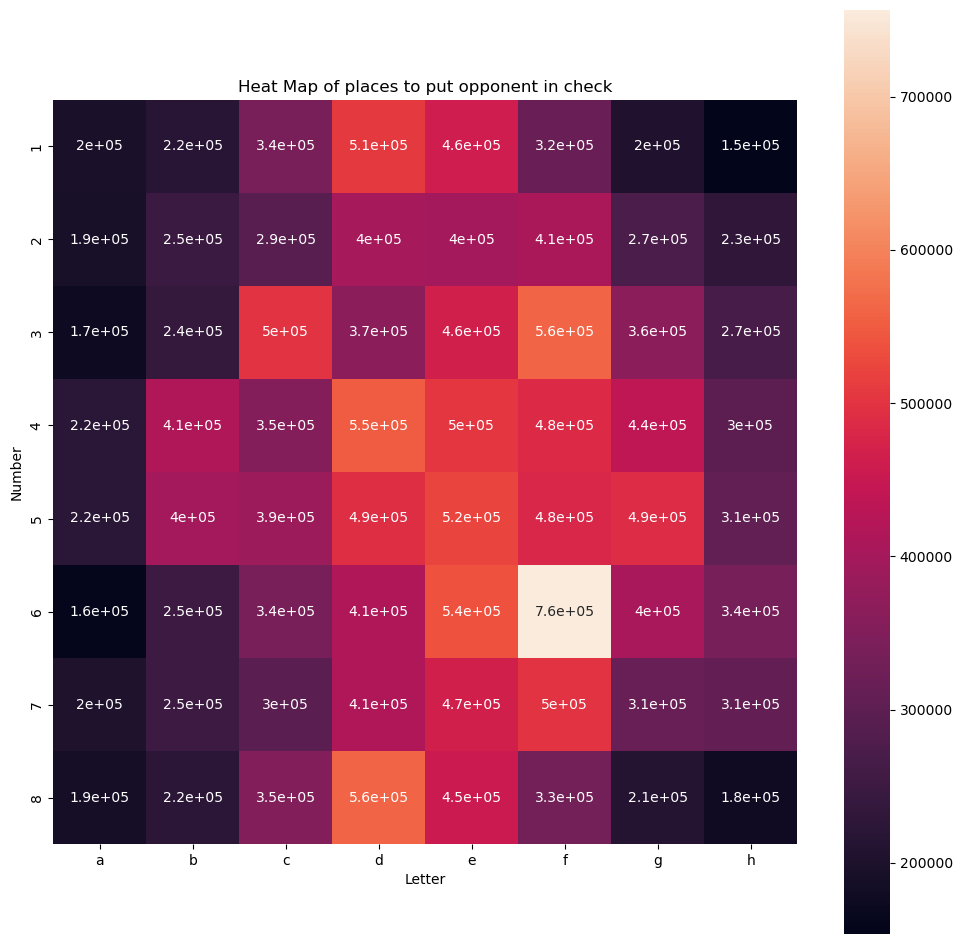

In [8]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

df = pd.DataFrame(check_list) 

cross_table = pd.crosstab(df['Number'], df['Letter']) #create cross table for chess positions 
cross_table.sort_index(inplace=True) 

plt.figure(figsize=(12,12)) #generate the heat map 
plt.title('Heat Map of places to put opponent in check')
a = sns.heatmap(cross_table, square=True, annot=True, linecolor='black')          
plt.show()    

# Bar Chart to show amount of caputered peices by a respective Peice 

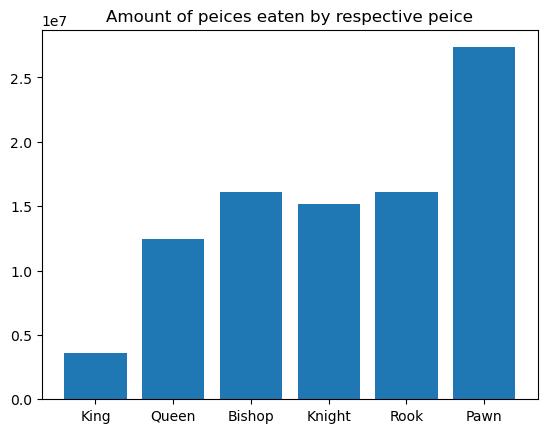

In [9]:
peices = list(peice_dict.keys()) #get x and y axis 
values = list(peice_dict.values())

plt.title('Amount of peices eaten by respective peice') #plot the bar chart 
plt.bar(range(len(peice_dict)), values, tick_label = peices)
plt.show()

# Density plot to show how the 'level of the game' (elo score) & it's length
## Fitted with a regression line to see if there is a correlation 

#### Two plots are generated one showing the discrepency between player scores and if there is a relation between the number of moves in the game. Whilst the other takes into account the elo of the game (player A elo + player B elo) and checks if there is a relation between the amount of moves. The moves is considered as dependent variable. Two line fits are generated one for each density plot. 

The below cell will sometimes output a warning - all nan slice runtime warning 
This is not an issue from my part but an outstanding issue in mpl scatter density (version = 0.7) at the time of writing - https://github.com/astrofrog/mpl-scatter-density/issues/35

This warning leaves if the cell is rerun again 

Reason as why this happens: 

The issue is caused by the call self.set_array(EMPTY_IMAGE) in base_image_artist.py(70);
EMPTY_IMAGE is an array with a single Nan entry
At some point this calls vmin = self._density_vmin(array) in generic_density_artist.py(77)
and this generates the warning.


Reason why I opted for this package: speed and compatability with matplotlib, and it does not effect my output  


/home/wayne/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/wayne/anaconda3/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


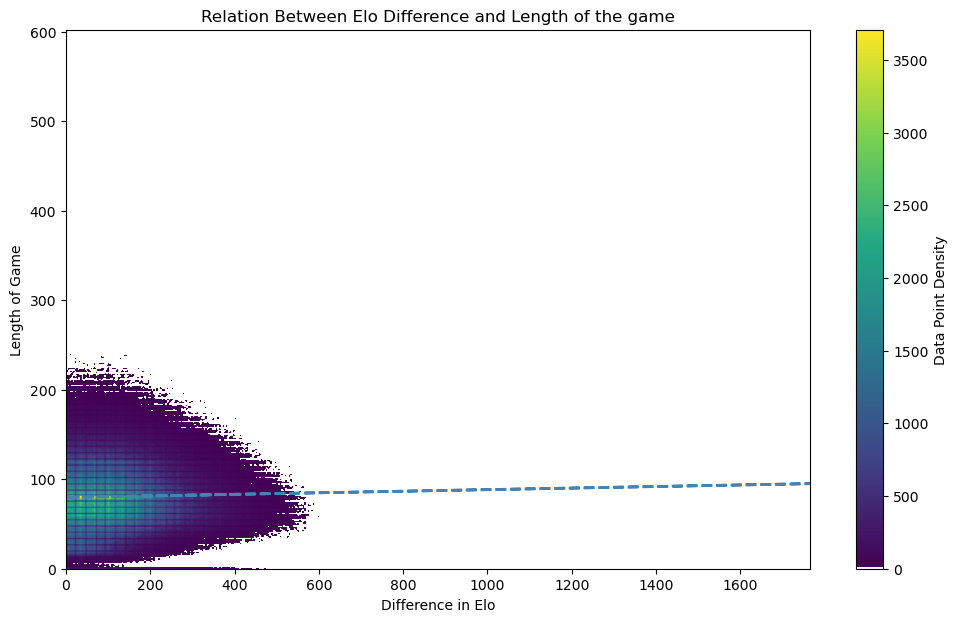

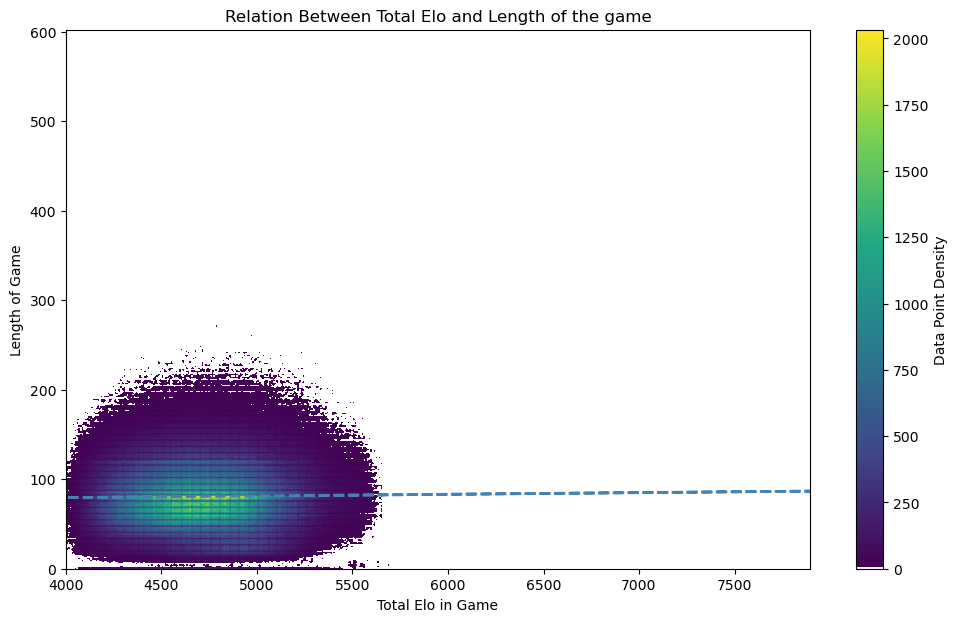

In [10]:
indep_var_1 = [] 
indep_var_2 = [] 
dep_var = []

for i in range(len(elo_length_of_game)): #get the x and y axis 
    indep_var_1.append(elo_length_of_game[i]['EloDifference'])
    indep_var_2.append(elo_length_of_game[i]['TotalScore'])
    dep_var.append(elo_length_of_game[i]['Moves'])

a_1,b_1 = np.polyfit(indep_var_1, dep_var, 1) #line of best fit within data  
a_2, b_2 = np.polyfit(indep_var_2, dep_var, 1) #same as above for the total score


#color map 
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

#first figure 

fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1, projection = 'scatter_density')

density = ax.scatter_density(indep_var_1, dep_var, cmap=white_viridis) #density plot 
fig.colorbar(density, label='Data Point Density')

#linear regression line fit 
plt.plot(indep_var_1, np.multiply(a_1,indep_var_1)+b_1, color='steelblue', linestyle='--', linewidth=2)


plt.xlabel('Difference in Elo')
plt.ylabel('Length of Game')
plt.title('Relation Between Elo Difference and Length of the game')

#second figure 
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1, projection = 'scatter_density')

density = ax.scatter_density(indep_var_2, dep_var, cmap=white_viridis)
fig.colorbar(density, label='Data Point Density')

#linear regression line fit 
plt.plot(indep_var_2, np.multiply(a_2,indep_var_2)+b_2, color='steelblue', linestyle='--', linewidth=2)

plt.xlabel('Total Elo in Game')
plt.ylabel('Length of Game')
plt.title('Relation Between Total Elo and Length of the game')
plt.show()



# Chess Popularity across the decades 

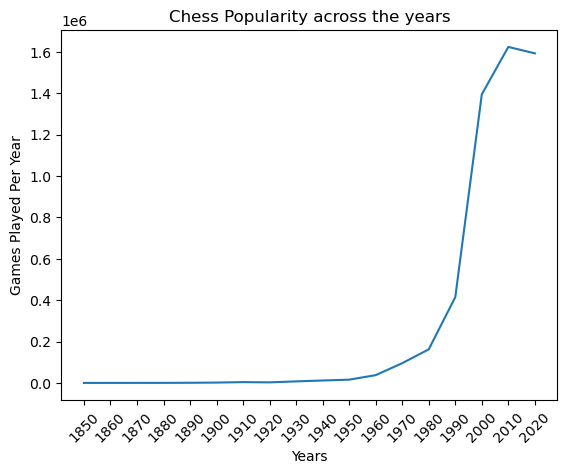

In [11]:
from collections import OrderedDict

ord_dict = OrderedDict(sorted(games_played_per_year.items())) #sort the dictionary by year 

year_agg_10 = 0 
processed_ord_dict = {} 
for key in ord_dict.keys():  
    
    year_agg_10 += ord_dict[key] #aggregate 10 year data
    
    if int(key) % 10 == 0: #every 10 years create a new data point 
        processed_ord_dict.update({key : year_agg_10})
        year_agg_10 = 0  

years = list(processed_ord_dict.keys()) #get x and y axis from the new dictionary  
amounts = list(processed_ord_dict.values())

plt.plot(years, amounts) #plot line graph 
plt.title('Chess Popularity across the years')
plt.xlabel('Years')
plt.ylabel('Games Played Per Year')

#cater for size 
plt.rcParams['figure.figsize'] = [15,15]
plt.xticks(rotation=45)
plt.show()

# Is there a significant difference in the mean number of moves in chess a game & the winning player ratings?

## We begin by verifying that the welch t-test assumptions holds 

### Normality Test  

To check for normality a visual test was used, where a histogram is depicted along with its mean median and mode. It also overlayed with data points which were normally generated to further emphasize this point. The reason a normality test was not used is justified below 

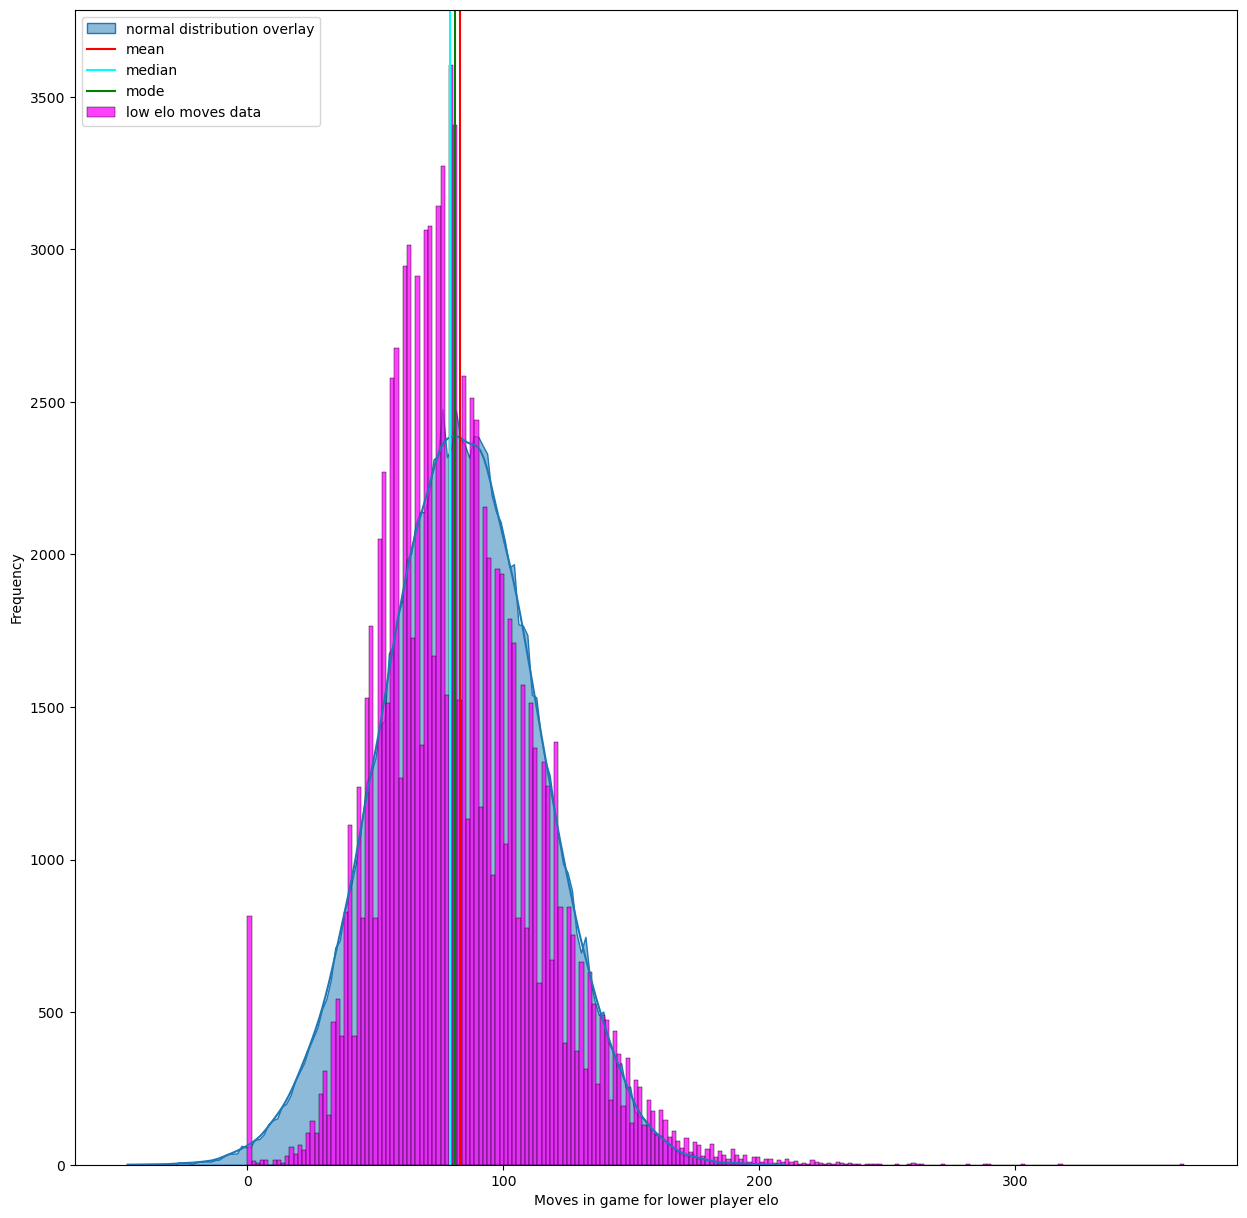

In [12]:
# Note that several tests were tried, however they all failed some conditions: 
# I.e shapiro-wilk - better on a small data set, suffers when repeated values exist in the data set 
# Anderson-darling - suffers with repeated values 
# kolmorgrov-smirnov - requires continuous data 
#Instead a visual test was applied in this case 


low_elo_moves = [] 
high_elo_moves = [] 

for key in t_test_data.keys():# split moves into two lists 
    for i in range(len(t_test_data[key])):
            if(key == 'low_elo_sample'):
                low_elo_moves.append(t_test_data[key][i]['moves'])
            else:
                high_elo_moves.append(t_test_data[key][i]['moves'])
                
                
np.random.seed(5) #calculations 
mean = np.mean(low_elo_moves)
mode = max(set(low_elo_moves), key=low_elo_moves.count)
median = np.median(low_elo_moves)

overlay = np.random.normal(mean, np.std(low_elo_moves), len(low_elo_moves)) #normal distribution overlay 

ax2 = sns.histplot(overlay, kde=True, element='poly', label='normal distribution overlay') #plot overlay 

ax1 = sns.histplot(low_elo_moves, color='magenta', label='low elo moves data')#histogram 
plt.xlabel("Moves in game for lower player elo")
plt.ylabel("Frequency")

ax3 = plt.axvline(x=mean, color='red', label = 'mean') #plot lines 
ax4 = plt.axvline(x=median, color='cyan', label = 'median')
ax5 = plt.axvline(x=mode, color='green', label = 'mode')


ax1.legend(loc="upper left") #legend
ax2.legend(loc="upper left")
plt.show()

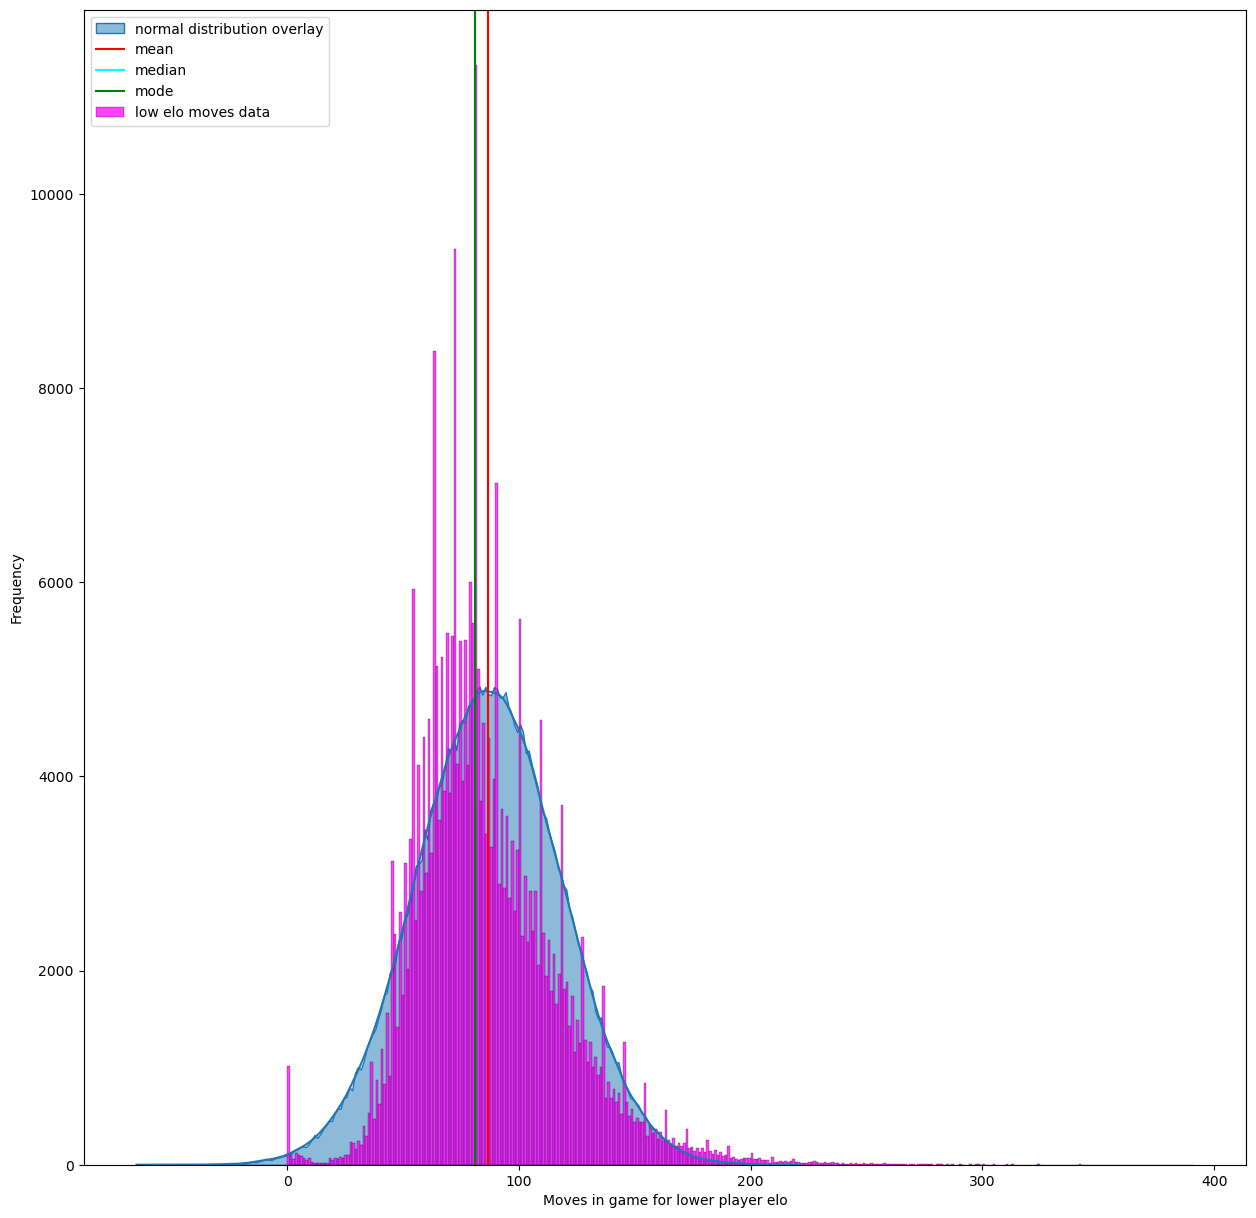

In [13]:
np.random.seed(0) #calculations 
mean = np.mean(high_elo_moves)
mode = max(set(high_elo_moves), key=high_elo_moves.count)
median = np.median(high_elo_moves)

overlay = np.random.normal(mean, np.std(high_elo_moves), len(high_elo_moves)) #normal distribution overlay 

ax2 = sns.histplot(overlay, kde=True, element='poly', label='normal distribution overlay') #plot overlay 

ax1 = sns.histplot(high_elo_moves, color='magenta', label='low elo moves data')#histogram 
plt.xlabel("Moves in game for lower player elo")
plt.ylabel("Frequency")

ax3 = plt.axvline(x=mean, color='red', label = 'mean') #plot lines 
ax4 = plt.axvline(x=median, color='cyan', label = 'median')
ax5 = plt.axvline(x=mode, color='green', label = 'mode')


ax1.legend(loc="upper left") #legend
ax2.legend(loc="upper left")
plt.show()

### Variance Equality Test  

In [14]:
res = scipy.stats.levene(high_elo_moves, low_elo_moves, center = 'mean')


if(res.pvalue < 0.05):
    print("Rejecting the null hypothesis that the groups have equal variance")

Rejecting the null hypothesis that the groups have equal variance


### Welch Test Results  

In [15]:
res = scipy.stats.ttest_ind(high_elo_moves, low_elo_moves, equal_var = False)

if(res.pvalue < 0.05):
    print("Rejecting the null hypothesis that the means are equal")
else: 
    print("Means are equal as stated by null hypothesis")

Rejecting the null hypothesis that the means are equal


## Conclusion: There is statistical significance between the means of the games of winners where the player rating ranges either from 2000-2075 or 2600+

# Bad Visualisation 
## Article: https://www.wired.com/story/is-your-chart-a-detective-story-or-a-police-report/
## Media Source: Wired

This cell produces a warning that my ubuntu version does not have some themes which may be needed to display the picture, however this warning is redunant 

In [16]:
from PIL import Image 

im = Image.open("BadVisual.png")
im.show()
    

This image contains several misleading and useless aspects. To start off the use of a circular represtation can be classified as chart junk, since it represents no useful way of presenting the data, rather quite the opposite since reading the dosages around the turns is quite confusing. <br> 


Furthmore more, the scale is inverted, here higher bars imply better antibiotics (claimed in the article) however at first glance it is easy to mistake this as more resistance bacteria. Lastly it makes use of two colours schemes in one chart, another aspect that can be jotted down as chart junk since this could be split into two seperate bar charts, one for bacteria with a positive gram stain and the other for negative.

# How I would present the data

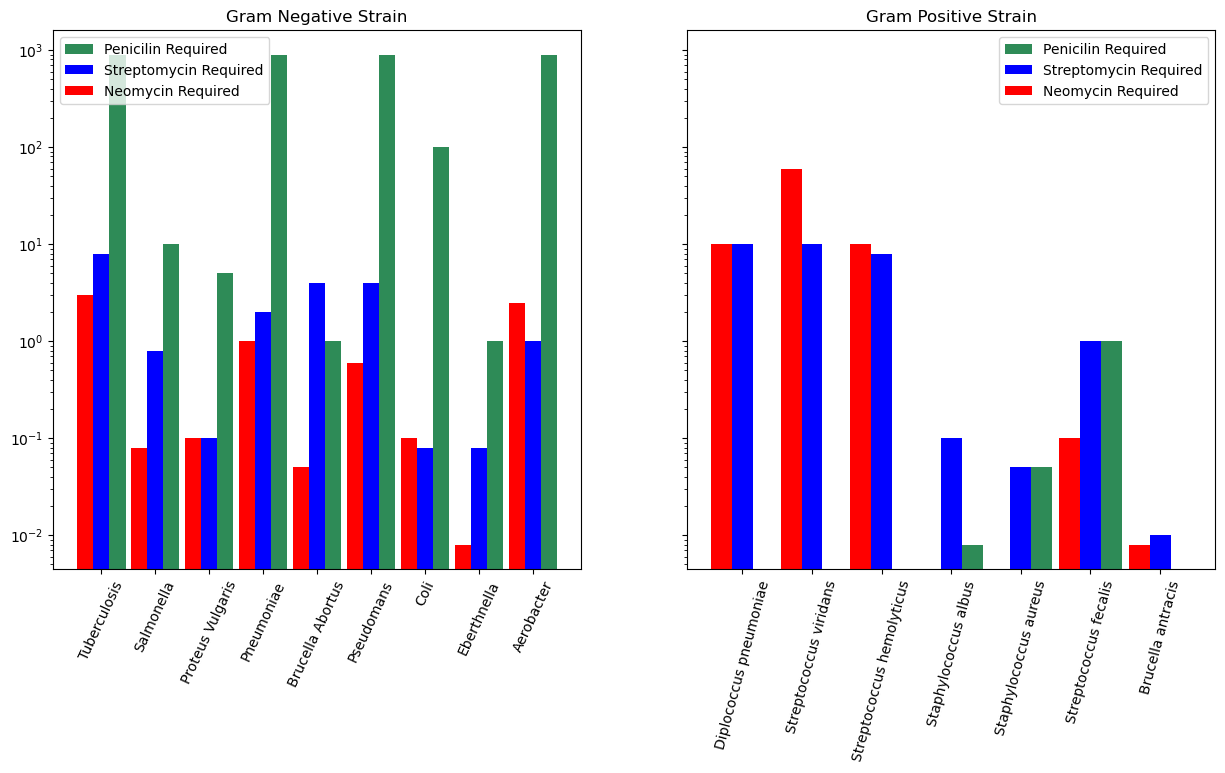

In [20]:
data_negative_gram_strain = {"Bacteria" : ["Tuberculosis", "Salmonella", "Proteus Vulgaris", 
                                           "Pneumoniae", "Brucella Abortus", "Pseudomans", "Coli",
                                            "Eberthnella", "Aerobacter"],
                            "Penicillin Required" : [900, 10, 5, 900, 1, 900, 100, 1, 900],
                            "Streptomycin Required" : [8, 0.8, 0.1, 2, 4, 4, 0.08, 0.08, 1],
                            "Neomycin Required": [3, 0.08, 0.1, 1, 0.05, 0.6, 0.1, 0.008, 2.5]}


data_positive_gram_strain = {"Bacteria" : ["Diplococcus pneumoniae", "Streptococcus viridans", 
                                           "Streptococcus hemolyticus", "Staphylococcus albus",
                                          "Staphylococcus aureus", "Streptococcus fecalis", "Brucella antracis"],
                            "Penicillin Required": [0.004, 0.004, 0.001, 0.008, 0.05, 1, 0.001], 
                            "Streptomycin Required": [10, 10, 8, 0.1, 0.05, 1, 0.01], 
                            "Neomycin Required": [10, 60, 10, 0.001, 0.001, 0.1, 0.008]}


df_1 = pd.DataFrame(data_negative_gram_strain)
df_2 = pd.DataFrame(data_positive_gram_strain)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,7), sharey = True) #2 subplots 

#Plot Left Side 

N_1 = len(df_1["Bacteria"]) #details for plot one 
ind_1 = np.arange(N_1) #index 
width = 0.3
idx_1 = np.asarray([i for i in range(len(df_1["Bacteria"]))]) #x ticks index 

#bars 
rects1 = axes[0].bar(ind_1+width, df_1["Penicillin Required"], width, color="seagreen")
rects2 = axes[0].bar(ind_1, df_1["Streptomycin Required"], width, color="blue")
rects3 = axes[0].bar(ind_1-width, df_1["Neomycin Required"], width, color="red")

#axes,title and legend
axes[0].set_xticks(idx_1)
axes[0].set_xticklabels(df_1["Bacteria"], rotation=65)

axes[0].legend( (rects1[0], rects2[0],rects3[0]) , 
               ('Penicilin Required', 'Streptomycin Required', 'Neomycin Required'))
axes[0].set_title('Gram Negative Strain')


axes[0].set_yscale('log') #setting y scale to logarithmic to prevent dwarfing figures 


#Plot Right side 

N_2 = len(df_2["Bacteria"]) #spacing 
ind_2 = np.arange(N_2)
idx_2 = np.asarray([i for i in range(len(df_2["Bacteria"]))])

#bars 
rects4 = axes[1].bar(ind_2+width, df_2["Penicillin Required"], width, color="seagreen")
rects5 = axes[1].bar(ind_2, df_2["Streptomycin Required"], width, color="blue")
rects6 = axes[1].bar(ind_2-width, df_2["Neomycin Required"], width, color="red")

#scale,title and legend 
axes[1].set_xticks(idx_2)
axes[1].set_xticklabels(df_2["Bacteria"], rotation=75)
axes[1].legend( (rects4[0], rects5[0], rects6[0]) , 
              ('Penicilin Required', 'Streptomycin Required', 'Neomycin Required')) 
axes[1].set_title('Gram Positive Strain')
axes[1].set_yscale('log')

plt.show()